<a href="https://colab.research.google.com/github/kishansheth/interfaces-hw1/blob/master/Interfaces_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Combination Lock - Visual Interfaces HW1
Kishan Sheth (kps2138)

Professor John Kender



##1.1 Domain Engineering Step

For this project, my domain includes my Nikon D5300 DSLR (mounted on a tripod), a black sheet as a backdrop, and my own hand as the subject.

**Camera & Backdrop**

To set up the domain, first, I hung the black sheet from the bunk beds near my desk. Next, I mounted my camera on my tripod and placed this apparatus on my desk. Finally, I marked the location of the tripod on my desk to ensure I take pictures at a consistent distance from the backdrop. 

**Lighting**

To ensure that lighting is consistent, I decided to only use the overhead light in my dorm room and to close the blinds so minimal light could enter through the window. I also kept my camera settings consistent for all images I captured.

**Tools and Environment**

For both the narrative and coding portion of this project, I decided to use a Jupyter Notebook format, hosted on Google Colab. I use OpenCV in Python because I am most familiar with Python for computer vision work. Google Colab is advantageous because it allows me to combine text and code seamlessly. It also comes preloaded with OpenCV, NumPy, and several other useful packages for computer vision tasks.

In [0]:
# Import OpenCV, NumPy, and image viewers
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [3]:
# Connect Google Colab to Google Drive to allow file access
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Interfaces/HW1/images

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Interfaces/HW1/images


**Image Preprocessing**

My DSLR is set to shoot RGB images with dimensions 4496 x 3000 x 3, which is a little large for quick image processing (approximately 6MB per image). Thus, before processing, I resize each image by a factor of 1/8 using OpenCV's `resize()` function, yielding final images of dimensions 562 x 375 x 3 (approximately 49KB per image). 

In [0]:
# Input: image
# Returns: downscaled and denoised image
def preprocess(im):

  # scale image by factor of 1/8
  im = cv2.resize(im, (int(im.shape[1]/8), int(im.shape[0]/8)))

  # blur to reduce noise
  im = cv2.blur(im, (3,3))

  return im

[291.  197.5]
[291.65246582 199.45187378]
[0, 1]


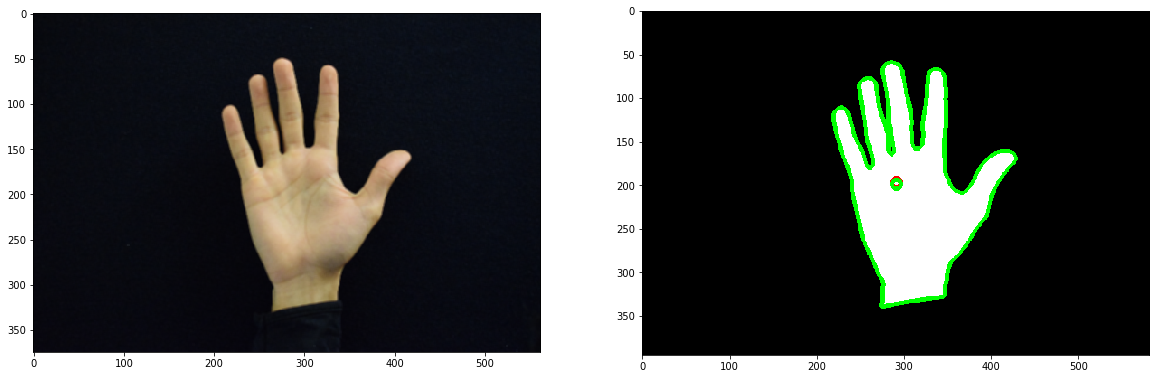

[291.  197.5]
[303.5 244. ]
[0, 0]


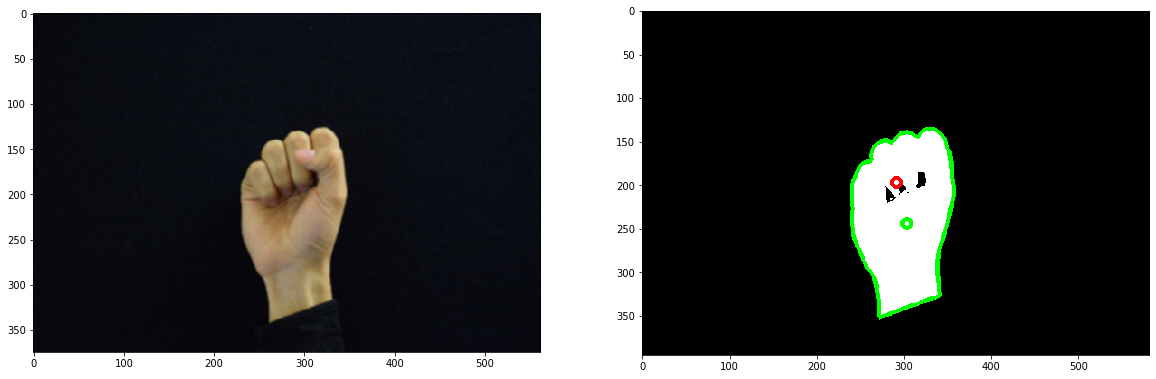

[291.  197.5]
[259.  188.5]
[0, 0]


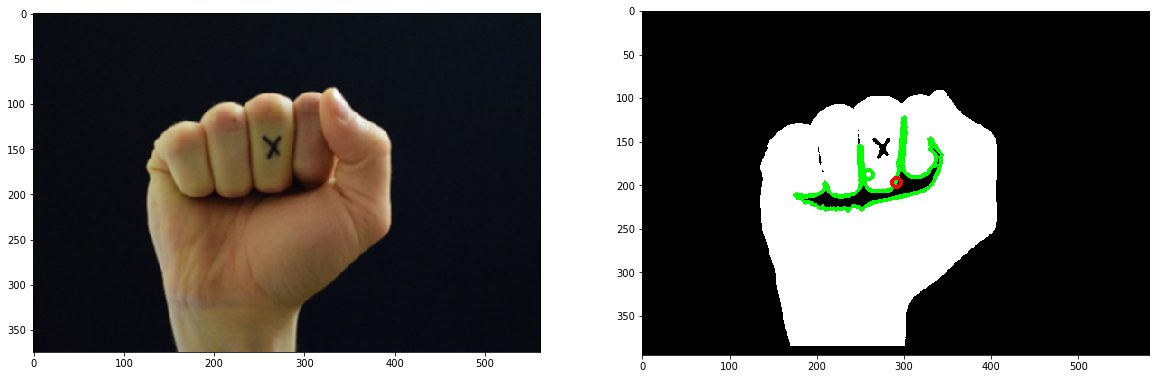

[291.  197.5]
[168. 167.]
[1, 1]


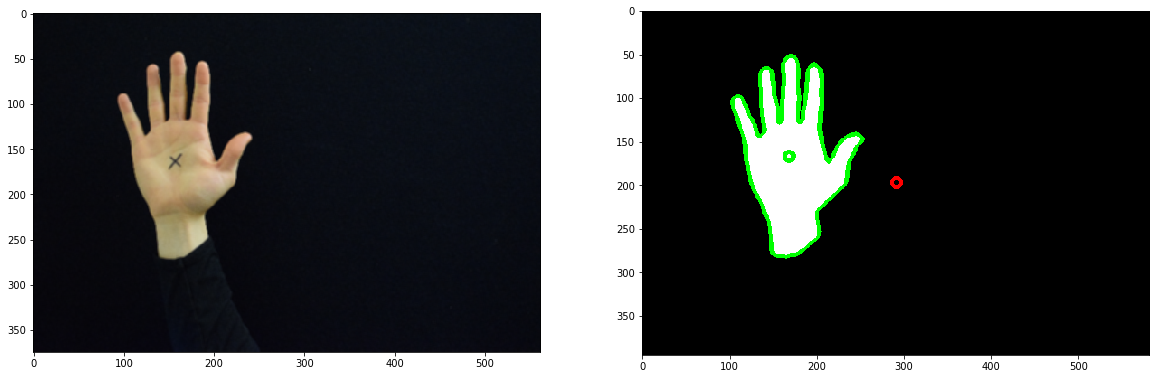

[[0, 1], [0, 0], [0, 0], [1, 1]]


In [86]:
main_seq = ['open_center2.jpg', 'closed_center.jpg', 'ben/8_c_f.JPG', 'ben/1_tl_s.JPG']

# Input: sequence of image filenames
# Returns: a list of (location, position) tuples of detected hands 
def analyze_sequence(seq):
  predictions = []

  for img_name in seq:

    # read image from Drive
    orig_img = cv2.imread(img_name)
    processed_img = preprocess(orig_img)
    img = binary_skin_mask(processed_img.copy())

    # find main contour
    main_contour = find_contour(img)
    perimeter = cv2.arcLength(main_contour,True)  # get contour perimeter
    center, radius = cv2.minEnclosingCircle(main_contour) # get contour center

    # convert back to RGB in order to add perimeter and center mark
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # draw perimeter and center mark
    cv2.drawContours(img, [main_contour], 0, (0,255,0), 3)

    cv2.circle(img, (int(img.shape[1]/2), int(img.shape[0]/2)), 5, (255,0,0), 3)
    cv2.circle(img, (int(center[0]), int(center[1])), 5, (0,255,0), 3)

    # use center and perimeter to predict symbol
    prediction = predict(img.shape, center, perimeter)
    predictions.append(prediction)


    # display image
    plt.rcParams["figure.figsize"] = (20,10)

    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    axarr[1].imshow(img)
    # plt.imshow(img)
    plt.show()
  
  return predictions

pred = analyze_sequence(main_seq)
print(pred)


##1.2 Data Reduction Step

In this step, I use various methods from the OpenCV package to determine what portions of the image are skin versus backdrop. 

**Detecting Skin**

As Professor Kender has mentioned in class, skin is fundamentally the color of blood. Therefore, using a custom `binary_skin_mask()` function, we can create a mask over pixels that are within the range of the color of blood. [Research done by Kolkur et al.](https://arxiv.org/pdf/1708.02694.pdf) suggests that the color range of human skin can be roughly defined as follows:

0.0 <= H <= 50.0 and 0.23 <= S <= 0.68 

and R > 95 and G > 40 and B > 20 

and R > G and R > B

and | R - G | > 15 and A > 15

Although this is what the paper recommends, after some experimentation, I realized this color range doesn't account for some of the darker, or shadowed portions of the hand, given the lighting and subject (me) in my domain.

Therefore, I adjusted the parameters to account for my own domain. I reduced the R threshold to be R > 65 instead of R > 95.



In [0]:
# Turns image from RGB to Binary, separating skin from dark backdrop
# Input: RGB image
# Returns: Binary image - skin is white, backdrop is black
def binary_skin_mask(im):

  # set all pixels with color of skin to white
  for i in range(im.shape[0]):
    for j in range(im.shape[1]):
      pix = im[i][j]
      
      # reverse order because file is in BGR format
      r = pix[2]
      g = pix[1]
      b = pix[0]

      # set skin-colored pixels to white, using Kolkur et al.'s thresholds
      if r>60 and g>40 and b>20 and r>g and r>b:
        im[i][j] = np.array([255, 255, 255])

  # add border to image (helpful for contouring)
  im = cv2.copyMakeBorder(im, top=10, bottom=10, left=10, right=10, borderType= cv2.BORDER_CONSTANT, value=[0,0,0] ) 

  # convert to binary image, using 127 as B/W threshold
  ret, im = cv2.threshold(cv2.cvtColor(im, cv2.COLOR_RGB2GRAY),127,255,0)

  return im

**Contour Detection**

Once a binary image has been created, we can use the `findContours()` function in OpenCV to find an approximate border of the hand. I use documentation from [Contours in OpenCV](https://docs.opencv.org/trunk/d3/d05/tutorial_py_table_of_contents_contours.html) for reference. In the images, the largest detected contour is displayed in green.

**Contour Perimeter**

**Contour Center of Mass**

In [0]:
# Finds the main contour in an image, discarding negligible ones
# Input: Binary image
# Returns: Main contour of image
def find_contour(im):

  contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # find contour with the most points, ignoring small gaps and noise
  main_len = 0
  main_contour = []

  for contour in contours:
    if len(contour) > main_len:
      main_len = len(contour)
      main_contour = contour

  return main_contour

###1.3 Parsing and Performance Step

In this step I define a grammar and analyze the performance of my system on 12 different sequences of images. 

**Defining a Grammar**

The grammar I choose to define in this step includes 5 different hand locations:

*   top-left
*   top-right
*   center
*   bottom-left
*   bottom-right

<img src="https://i.imgur.com/yPeRBw7.jpg" alt="Drawing" width=562/>

and 2 different hand positions:

*   fist
<img src="https://i.imgur.com/e2mKcQu.jpg" alt="Fist" width=300/>

*   splay
<img src="https://i.imgur.com/F3y3Yjj.jpg" alt="Splay" width=300/>





In [0]:
def predict(im_shape, cen, per):

  prediction = [-1, -1]

  # center is defined as no more than 0.25*Height pixels away from center
  center_threshold = 0.25*im_shape[0]

  # splayed if perimeter >= 1000, fist if < 1000
  perimeter_threshold = 1000

  x_center = im_shape[1]/2
  y_center = im_shape[0]/2

  x_pos = cen[0]
  y_pos = cen[1]

  # predict c, tl, tr, bl, br based on center
  actual_center = np.array((x_center, y_center))
  print(actual_center)
  hand_center = np.array((x_pos, y_pos))
  print(hand_center)

  # find distance from hand center to actual center
  dist = np.linalg.norm(actual_center-hand_center)

  if dist < center_threshold:
    prediction[0] = 0
  elif x_pos < x_center and y_pos < y_center:
    prediction[0] = 1
  elif x_pos > x_center and y_pos < y_center:
    prediction[0] = 2
  elif x_pos < x_center and y_pos > y_center:
    prediction[0] = 3
  else:
    prediction[0] = 4

  # predict fist or splayed based on perimeter
  if per < perimeter_threshold:
    prediction[1] = 0
  else:
    prediction[1] = 1

  print(prediction)

  

  return prediction